In [1]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import sys
sys.path.append("..")
import os
# avoid TF messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# set up plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
from IPython.display import clear_output
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
mpl.rcParams['animation.embed_limit'] = 2**128

c:\Users\carlo\anaconda3\envs\rl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carlo\anaconda3\envs\rl\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\carlo\anaconda3\envs\rl\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [3]:
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode='rgb_array')
env.reset()

((12, 5, 0), {})

# Random Agent

In [5]:
random_rewards = []
for episode in tqdm(range(1000)):
    obs = env.reset()[0]
    done = False
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info, _ = env.step(action)

    if reward == 0:
        reward += 0.1
    
    elif reward == -1:
        reward = -10
        
    random_rewards.append(reward) 

100%|██████████| 1000/1000 [00:00<00:00, 13925.36it/s]


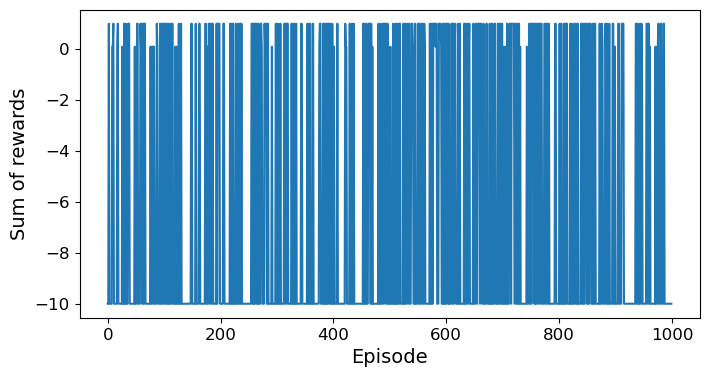

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(random_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

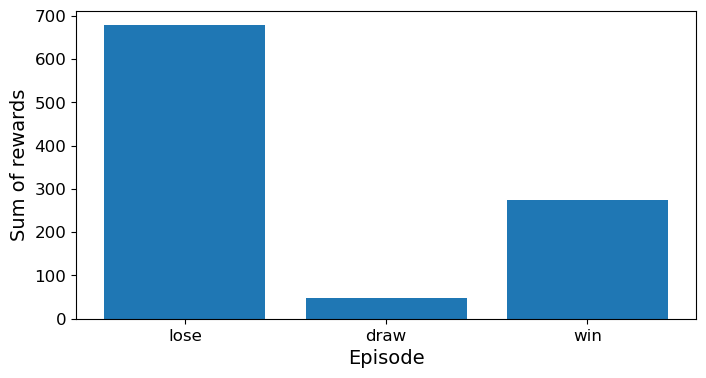

In [7]:
random_reward_counts = [random_rewards.count(i) for i in [-10, 0.1, 1]]
plt.figure(figsize=(8, 4))
plt.bar(x=["lose", 'draw', 'win'],height=random_reward_counts)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

# DQN

In [8]:
keras.backend.clear_session()
input_shape = [3] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(128, activation="elu", input_shape=input_shape),
    keras.layers.Dense(64, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [9]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict([state], verbose=0)[0]
        return np.argmax(Q_values)

In [10]:
from collections import deque
replay_memory = deque(maxlen=2000)

In [11]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [12]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info, _ = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [13]:
batch_size = 200
discount_rate = 0.8
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [14]:
#########  MODEL TRAINING 
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
for episode in tqdm(range(2000)):
    epsilon = max(1 - episode / 500, 0.01)
    obs = env.reset()[0]
    done = False

    while not done:
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        
    if reward == 0:
        reward += 0.1

    elif reward == -1:
        reward = -100
        
    rewards.append(reward) # Not shown 

    if episode > batch_size:
        training_step(batch_size)

100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]


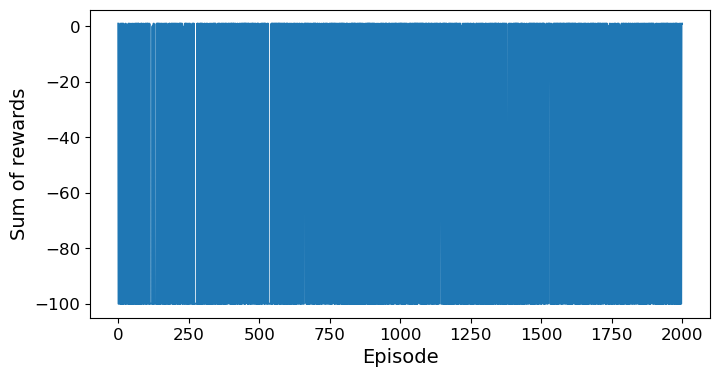

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

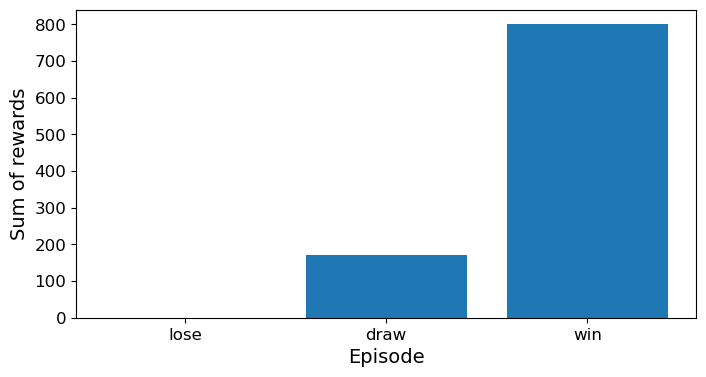

In [16]:
reward_counts = [rewards.count(i) for i in [-10, 0.1, 1]]
plt.figure(figsize=(8, 4))
plt.bar(x=["lose", 'draw', 'win'],height=reward_counts)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()